In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(1562, 24)
(1562, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24126466,  0.12416799, -0.38245061,  0.23819205,
       -0.13101307, -0.37997335, -0.25759894,  0.12540799, -0.38777819,
       -0.2609376 , -0.12951526, -0.38073996,  0.01169242,  0.0080791 ,
       -0.01588985, -0.0221573 ,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24126466,  0.12416799, -0.38245061,  0.23819205,
       -0.13101307, -0.37997335, -0.25759894,  0.12540799, -0.38777819,
       -0.2609376 , -0.12951526, -0.38073996,  0.01169242,  0.0080791 ,
       -0.01588985, -0.0221573 ,  0.        ,  1.        ])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.985805893928663
RMSE:  0.014898472166564829
The lowest error is:  0.000146679907974262
The highest error is:  0.07577236207160931
The avg. error is:  0.009569369276321167


In [11]:
model_rl_relative_swinging_x.coef_

array([[ 1.98829811e-02, -5.55111512e-17, -1.24900090e-16,
         1.74772141e-01,  1.38777878e-16,  3.33066907e-16,
         1.31325617e-01, -2.10674328e-01,  3.82382374e-01,
        -1.18533655e+00, -2.71575963e-01,  4.42101493e-01,
        -1.45394852e+00, -3.47238295e-02, -3.07516821e-01,
         6.78927974e-01]])

In [12]:
model_rl_relative_swinging_x.intercept_

array([-0.1783594])

Text(0, 0.5, 'Predictions')

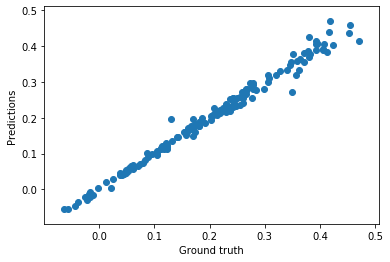

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [15]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.37758685347503107
RMSE:  0.007189269709661169
The lowest error is:  2.295106475307812e-05
The highest error is:  0.025775309378345546
The avg. error is:  0.005462445776401235


In [16]:
model_rl_relative_swinging_y.coef_

array([[ 8.39730913e-03,  4.83987850e-16,  2.86229374e-17,
         3.05259911e-03,  5.55111512e-17, -1.11022302e-16,
        -7.75461461e-02, -1.03412815e-02,  1.94404265e-01,
         3.72094897e-01, -1.76476538e-01, -8.01011291e-01,
         1.04251361e-01, -1.46745788e+00,  1.94111021e-01,
         4.33070004e-01]])

In [17]:
model_rl_relative_swinging_y.intercept_

array([0.15823644])

Text(0, 0.5, 'Predictions')

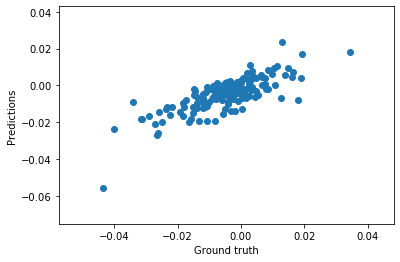

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')